In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Trying to reduce it: v4, One Head. 255 Normalization. Weighted for Precision. Little Dataset')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

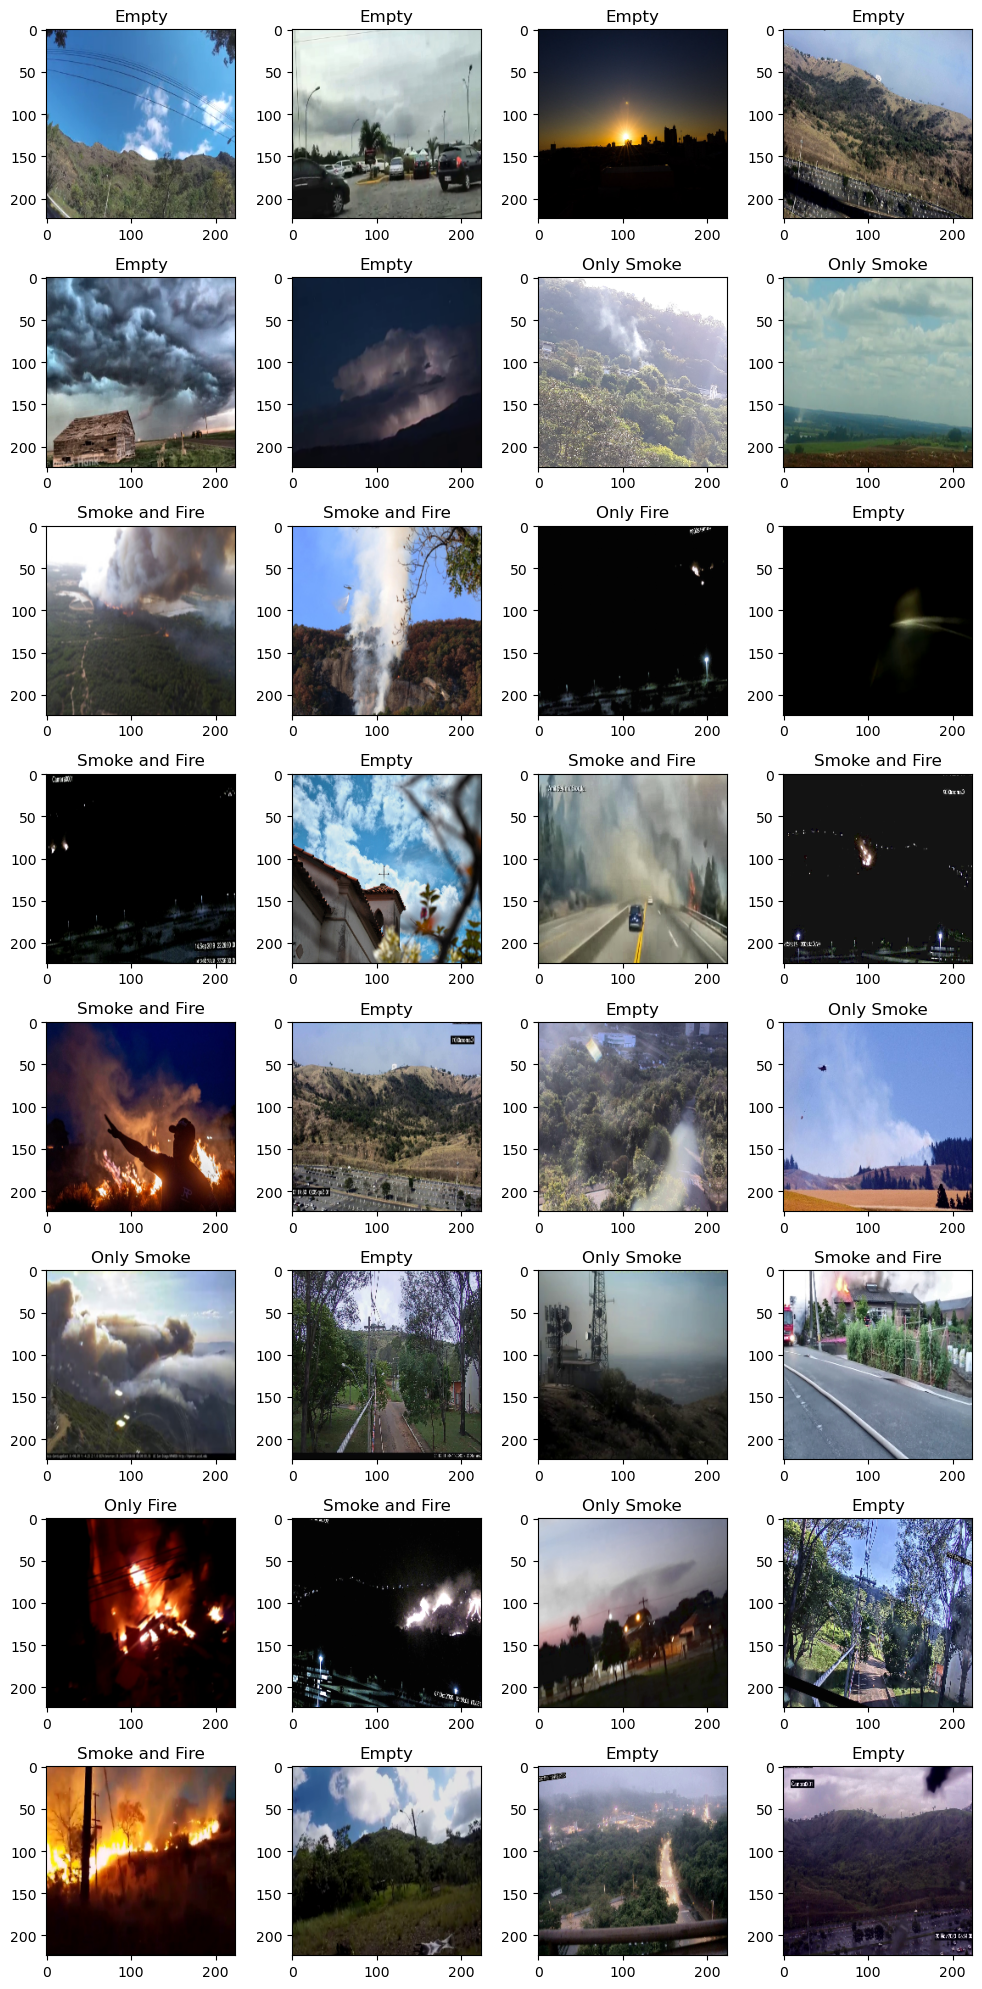

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(self.last_channels, affine=False),
            nn.ReLU(),

            # Output One Head, 2 Neurons
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=2),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-3
EPOCHS = 125 #100
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

TRAIN_DS_LEN = 8192
VAL_DS_LEN = 512


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = TRAIN_DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = VAL_DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 3714
DFire only smoke images: 2234
DFire only fire images: 474
DFire smoke and fire images: 1770
Train dataset len: 8192

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 241
DFire only smoke images: 141
DFire only fire images: 30
DFire smoke and fire images: 100
Test dataset len: 512


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[ 0.2087,  0.0140],
        [ 0.2634,  0.0460],
        [ 0.2952,  0.0957],
        [ 0.3453, -0.0097]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mo

# Main Function

In [18]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 11:32:48

Initializing Weights

=== EPOCH 0/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
72.230      |36.905      |35.325      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.492      |36.350      |27.142      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.529 - F1: 0.000
FIRE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.746 - F1: 0.000

Saving model with new best validation loss: 63.492

=== EPOCH 1/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.317      |36.493      |28.823      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.391      |35.777      |24.614      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.529 - F1: 0.000
FIRE -> Precision: 0.750 - Recall: 0.508 - Accuracy: 0.832 - F1: 0.606

Saving model with new best validation loss: 60.391

=== EPOCH 2/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.229      |36.306      |26.923      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.734      |35.854      |24.880      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.529 - F1: 0.000
FIRE -> Precision: 0.719 - Recall: 0.631 - Accuracy: 0.844 - F1: 0.672

=== EPOCH 3/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.489      |35.861      |25.629      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.437      |35.294      |22.144      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.529 - F1: 0.000
FIRE -> Precision: 0.787 - Recall: 0.538 - Accuracy: 0.846 - F1: 0.639

Saving model with new best validation loss: 57.437

=== EPOCH 4/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.430      |35.944      |24.486      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.103      |35.394      |21.709      

SMOKE -> Precision: 0.607 - Recall: 0.212 - Accuracy: 0.564 - F1: 0.314
FIRE -> Precision: 0.720 - Recall: 0.592 - Accuracy: 0.838 - F1: 0.650

Saving model with new best validation loss: 57.103

=== EPOCH 5/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.148      |35.524      |22.623      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.633      |34.358      |20.275      

SMOKE -> Precision: 0.773 - Recall: 0.282 - Accuracy: 0.623 - F1: 0.413
FIRE -> Precision: 0.798 - Recall: 0.700 - Accuracy: 0.879 - F1: 0.746

Saving model with new best validation loss: 54.633

=== EPOCH 6/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.389      |35.063      |22.326      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.972      |33.717      |18.255      

SMOKE -> Precision: 0.803 - Recall: 0.237 - Accuracy: 0.613 - F1: 0.365
FIRE -> Precision: 0.809 - Recall: 0.685 - Accuracy: 0.879 - F1: 0.742

Saving model with new best validation loss: 51.972

=== EPOCH 7/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.078      |34.575      |21.503      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.067      |32.970      |18.097      

SMOKE -> Precision: 0.817 - Recall: 0.278 - Accuracy: 0.631 - F1: 0.415
FIRE -> Precision: 0.840 - Recall: 0.685 - Accuracy: 0.887 - F1: 0.754

Saving model with new best validation loss: 51.067

=== EPOCH 8/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.097      |34.126      |20.972      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.834      |33.047      |17.787      

SMOKE -> Precision: 0.802 - Recall: 0.303 - Accuracy: 0.637 - F1: 0.440
FIRE -> Precision: 0.790 - Recall: 0.723 - Accuracy: 0.881 - F1: 0.755

Saving model with new best validation loss: 50.834

=== EPOCH 9/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.242      |33.690      |20.552      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.324      |32.316      |19.008      

SMOKE -> Precision: 0.796 - Recall: 0.307 - Accuracy: 0.637 - F1: 0.443
FIRE -> Precision: 0.856 - Recall: 0.638 - Accuracy: 0.881 - F1: 0.731

=== EPOCH 10/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.297      |33.224      |20.072      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.975      |31.779      |17.196      

SMOKE -> Precision: 0.813 - Recall: 0.361 - Accuracy: 0.660 - F1: 0.500
FIRE -> Precision: 0.818 - Recall: 0.692 - Accuracy: 0.883 - F1: 0.750

Saving model with new best validation loss: 48.975

=== EPOCH 11/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.306      |33.013      |19.293      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 13.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.671      |30.870      |16.801      

SMOKE -> Precision: 0.852 - Recall: 0.432 - Accuracy: 0.697 - F1: 0.573
FIRE -> Precision: 0.823 - Recall: 0.715 - Accuracy: 0.889 - F1: 0.765

Saving model with new best validation loss: 47.671

=== EPOCH 12/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.901      |32.628      |19.273      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.108      |31.793      |18.315      

SMOKE -> Precision: 0.881 - Recall: 0.307 - Accuracy: 0.654 - F1: 0.455
FIRE -> Precision: 0.878 - Recall: 0.608 - Accuracy: 0.879 - F1: 0.718

=== EPOCH 13/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.293      |32.282      |19.011      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.597      |31.097      |16.500      

SMOKE -> Precision: 0.816 - Recall: 0.349 - Accuracy: 0.656 - F1: 0.488
FIRE -> Precision: 0.891 - Recall: 0.692 - Accuracy: 0.900 - F1: 0.779

Saving model with new best validation loss: 47.597

=== EPOCH 14/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.529      |32.100      |18.429      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.654      |31.089      |15.565      

SMOKE -> Precision: 0.728 - Recall: 0.643 - Accuracy: 0.719 - F1: 0.683
FIRE -> Precision: 0.842 - Recall: 0.777 - Accuracy: 0.906 - F1: 0.808

Saving model with new best validation loss: 46.654

=== EPOCH 15/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.968      |31.583      |18.385      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.138      |30.063      |16.075      

SMOKE -> Precision: 0.762 - Recall: 0.506 - Accuracy: 0.693 - F1: 0.608
FIRE -> Precision: 0.811 - Recall: 0.823 - Accuracy: 0.906 - F1: 0.817

Saving model with new best validation loss: 46.138

=== EPOCH 16/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.861      |31.308      |17.554      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.026      |29.582      |15.444      

SMOKE -> Precision: 0.843 - Recall: 0.444 - Accuracy: 0.699 - F1: 0.582
FIRE -> Precision: 0.864 - Recall: 0.731 - Accuracy: 0.902 - F1: 0.792

Saving model with new best validation loss: 45.026

=== EPOCH 17/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.635      |31.061      |17.574      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.302      |30.199      |16.103      

SMOKE -> Precision: 0.884 - Recall: 0.315 - Accuracy: 0.658 - F1: 0.465
FIRE -> Precision: 0.927 - Recall: 0.685 - Accuracy: 0.906 - F1: 0.788

=== EPOCH 18/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.609      |31.060      |17.549      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.522      |30.156      |16.366      

SMOKE -> Precision: 0.824 - Recall: 0.369 - Accuracy: 0.666 - F1: 0.510
FIRE -> Precision: 0.947 - Recall: 0.685 - Accuracy: 0.910 - F1: 0.795

=== EPOCH 19/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.869      |30.666      |17.202      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.055      |29.541      |14.514      

SMOKE -> Precision: 0.750 - Recall: 0.622 - Accuracy: 0.725 - F1: 0.680
FIRE -> Precision: 0.903 - Recall: 0.785 - Accuracy: 0.924 - F1: 0.840

Saving model with new best validation loss: 44.055

=== EPOCH 20/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.358      |30.150      |17.207      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.661      |28.341      |14.320      

SMOKE -> Precision: 0.818 - Recall: 0.485 - Accuracy: 0.707 - F1: 0.609
FIRE -> Precision: 0.853 - Recall: 0.846 - Accuracy: 0.924 - F1: 0.849

Saving model with new best validation loss: 42.661

=== EPOCH 21/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.996      |30.101      |16.895      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.696      |28.407      |14.289      

SMOKE -> Precision: 0.809 - Recall: 0.527 - Accuracy: 0.719 - F1: 0.638
FIRE -> Precision: 0.835 - Recall: 0.854 - Accuracy: 0.920 - F1: 0.844

=== EPOCH 22/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.996      |29.830      |16.166      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.045      |30.970      |13.075      

SMOKE -> Precision: 0.862 - Recall: 0.311 - Accuracy: 0.652 - F1: 0.457
FIRE -> Precision: 0.926 - Recall: 0.769 - Accuracy: 0.926 - F1: 0.840

=== EPOCH 23/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.866      |29.714      |16.152      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.845      |27.451      |13.394      

SMOKE -> Precision: 0.831 - Recall: 0.552 - Accuracy: 0.736 - F1: 0.663
FIRE -> Precision: 0.857 - Recall: 0.831 - Accuracy: 0.922 - F1: 0.844

Saving model with new best validation loss: 40.845

=== EPOCH 24/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.101      |29.261      |15.840      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.163      |29.636      |15.528      

SMOKE -> Precision: 0.800 - Recall: 0.548 - Accuracy: 0.723 - F1: 0.650
FIRE -> Precision: 0.957 - Recall: 0.677 - Accuracy: 0.910 - F1: 0.793

=== EPOCH 25/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.481      |29.429      |16.052      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.025      |27.975      |15.050      

SMOKE -> Precision: 0.814 - Recall: 0.564 - Accuracy: 0.734 - F1: 0.667
FIRE -> Precision: 0.979 - Recall: 0.715 - Accuracy: 0.924 - F1: 0.827

=== EPOCH 26/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.041      |29.230      |15.811      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.298      |28.678      |14.620      

SMOKE -> Precision: 0.842 - Recall: 0.398 - Accuracy: 0.682 - F1: 0.541
FIRE -> Precision: 0.950 - Recall: 0.731 - Accuracy: 0.922 - F1: 0.826

=== EPOCH 27/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.982      |28.635      |15.348      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.677      |27.603      |13.075      

SMOKE -> Precision: 0.768 - Recall: 0.631 - Accuracy: 0.736 - F1: 0.692
FIRE -> Precision: 0.878 - Recall: 0.885 - Accuracy: 0.939 - F1: 0.881

Saving model with new best validation loss: 40.677

=== EPOCH 28/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.830      |28.061      |14.769      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.194      |26.418      |12.776      

SMOKE -> Precision: 0.804 - Recall: 0.631 - Accuracy: 0.754 - F1: 0.707
FIRE -> Precision: 0.915 - Recall: 0.823 - Accuracy: 0.936 - F1: 0.866

Saving model with new best validation loss: 39.194

=== EPOCH 29/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.790      |28.018      |14.773      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.765      |27.566      |13.199      

SMOKE -> Precision: 0.873 - Recall: 0.485 - Accuracy: 0.725 - F1: 0.624
FIRE -> Precision: 0.952 - Recall: 0.762 - Accuracy: 0.930 - F1: 0.846

=== EPOCH 30/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.866      |28.116      |14.750      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.654      |27.835      |15.819      

SMOKE -> Precision: 0.899 - Recall: 0.407 - Accuracy: 0.699 - F1: 0.560
FIRE -> Precision: 0.989 - Recall: 0.662 - Accuracy: 0.912 - F1: 0.793

=== EPOCH 31/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.777      |27.860      |14.917      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.477      |26.285      |13.192      

SMOKE -> Precision: 0.819 - Recall: 0.618 - Accuracy: 0.756 - F1: 0.704
FIRE -> Precision: 0.883 - Recall: 0.869 - Accuracy: 0.938 - F1: 0.876

=== EPOCH 32/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.920      |27.628      |14.291      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.970      |26.308      |12.662      

SMOKE -> Precision: 0.777 - Recall: 0.710 - Accuracy: 0.768 - F1: 0.742
FIRE -> Precision: 0.953 - Recall: 0.785 - Accuracy: 0.936 - F1: 0.861

Saving model with new best validation loss: 38.970

=== EPOCH 33/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.130      |26.891      |14.239      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.364      |26.585      |12.779      

SMOKE -> Precision: 0.841 - Recall: 0.527 - Accuracy: 0.730 - F1: 0.648
FIRE -> Precision: 0.938 - Recall: 0.808 - Accuracy: 0.938 - F1: 0.868

=== EPOCH 34/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.851      |27.198      |13.652      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.618      |26.049      |13.569      

SMOKE -> Precision: 0.855 - Recall: 0.465 - Accuracy: 0.711 - F1: 0.602
FIRE -> Precision: 1.000 - Recall: 0.738 - Accuracy: 0.934 - F1: 0.850

=== EPOCH 35/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.947      |27.008      |13.939      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.607      |25.302      |12.306      

SMOKE -> Precision: 0.808 - Recall: 0.647 - Accuracy: 0.762 - F1: 0.719
FIRE -> Precision: 0.971 - Recall: 0.769 - Accuracy: 0.936 - F1: 0.858

Saving model with new best validation loss: 37.607

=== EPOCH 36/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.566      |26.475      |14.092      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.742      |24.675      |12.067      

SMOKE -> Precision: 0.848 - Recall: 0.627 - Accuracy: 0.771 - F1: 0.721
FIRE -> Precision: 0.952 - Recall: 0.769 - Accuracy: 0.932 - F1: 0.851

Saving model with new best validation loss: 36.742

=== EPOCH 37/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.026      |26.277      |13.749      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 12.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.541      |24.797      |11.745      

SMOKE -> Precision: 0.798 - Recall: 0.656 - Accuracy: 0.760 - F1: 0.720
FIRE -> Precision: 0.876 - Recall: 0.869 - Accuracy: 0.936 - F1: 0.873

Saving model with new best validation loss: 36.541

=== EPOCH 38/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.296      |26.358      |13.939      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.437      |24.687      |11.750      

SMOKE -> Precision: 0.828 - Recall: 0.660 - Accuracy: 0.775 - F1: 0.734
FIRE -> Precision: 0.881 - Recall: 0.854 - Accuracy: 0.934 - F1: 0.867

Saving model with new best validation loss: 36.437

=== EPOCH 39/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.138      |26.035      |13.104      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.098      |25.415      |11.683      

SMOKE -> Precision: 0.843 - Recall: 0.556 - Accuracy: 0.742 - F1: 0.670
FIRE -> Precision: 0.948 - Recall: 0.838 - Accuracy: 0.947 - F1: 0.890

=== EPOCH 40/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.929      |26.331      |13.598      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.539      |23.917      |11.622      

SMOKE -> Precision: 0.819 - Recall: 0.693 - Accuracy: 0.783 - F1: 0.751
FIRE -> Precision: 0.907 - Recall: 0.823 - Accuracy: 0.934 - F1: 0.863

Saving model with new best validation loss: 35.539

=== EPOCH 41/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.267      |26.031      |13.236      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.055      |26.108      |11.947      

SMOKE -> Precision: 0.851 - Recall: 0.523 - Accuracy: 0.732 - F1: 0.648
FIRE -> Precision: 0.954 - Recall: 0.792 - Accuracy: 0.938 - F1: 0.866

=== EPOCH 42/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.449      |25.876      |13.572      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.017      |24.229      |11.788      

SMOKE -> Precision: 0.822 - Recall: 0.689 - Accuracy: 0.783 - F1: 0.749
FIRE -> Precision: 0.877 - Recall: 0.877 - Accuracy: 0.938 - F1: 0.877

=== EPOCH 43/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.847      |25.725      |13.122      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.093      |24.519      |11.573      

SMOKE -> Precision: 0.801 - Recall: 0.768 - Accuracy: 0.801 - F1: 0.784
FIRE -> Precision: 0.889 - Recall: 0.862 - Accuracy: 0.938 - F1: 0.875

=== EPOCH 44/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.269      |25.338      |12.930      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.128      |24.260      |11.868      

SMOKE -> Precision: 0.833 - Recall: 0.581 - Accuracy: 0.748 - F1: 0.685
FIRE -> Precision: 0.946 - Recall: 0.815 - Accuracy: 0.941 - F1: 0.876

=== EPOCH 45/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.315      |25.388      |12.928      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.117      |23.654      |11.463      

SMOKE -> Precision: 0.832 - Recall: 0.676 - Accuracy: 0.783 - F1: 0.746
FIRE -> Precision: 0.981 - Recall: 0.785 - Accuracy: 0.941 - F1: 0.872

Saving model with new best validation loss: 35.117

=== EPOCH 46/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.939      |24.929      |13.010      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.212      |24.097      |11.115      

SMOKE -> Precision: 0.836 - Recall: 0.593 - Accuracy: 0.754 - F1: 0.694
FIRE -> Precision: 0.924 - Recall: 0.846 - Accuracy: 0.943 - F1: 0.884

=== EPOCH 47/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.919      |25.008      |12.911      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.606      |23.596      |11.010      

SMOKE -> Precision: 0.803 - Recall: 0.780 - Accuracy: 0.807 - F1: 0.792
FIRE -> Precision: 0.904 - Recall: 0.869 - Accuracy: 0.943 - F1: 0.886

Saving model with new best validation loss: 34.606

=== EPOCH 48/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.190      |24.882      |12.308      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.550      |23.263      |11.287      

SMOKE -> Precision: 0.825 - Recall: 0.685 - Accuracy: 0.783 - F1: 0.748
FIRE -> Precision: 0.957 - Recall: 0.854 - Accuracy: 0.953 - F1: 0.902

Saving model with new best validation loss: 34.550

=== EPOCH 49/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.832      |24.374      |12.458      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.052      |24.027      |12.025      

SMOKE -> Precision: 0.883 - Recall: 0.598 - Accuracy: 0.773 - F1: 0.713
FIRE -> Precision: 0.972 - Recall: 0.792 - Accuracy: 0.941 - F1: 0.873

=== EPOCH 50/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.407      |24.572      |12.834      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.457      |22.652      |10.805      

SMOKE -> Precision: 0.832 - Recall: 0.739 - Accuracy: 0.807 - F1: 0.782
FIRE -> Precision: 0.911 - Recall: 0.862 - Accuracy: 0.943 - F1: 0.885

Saving model with new best validation loss: 33.457

=== EPOCH 51/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.520      |24.863      |12.657      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.488      |23.222      |11.266      

SMOKE -> Precision: 0.840 - Recall: 0.697 - Accuracy: 0.795 - F1: 0.762
FIRE -> Precision: 0.956 - Recall: 0.838 - Accuracy: 0.949 - F1: 0.893

=== EPOCH 52/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.197      |24.524      |12.673      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.472      |22.965      |10.508      

SMOKE -> Precision: 0.781 - Recall: 0.813 - Accuracy: 0.805 - F1: 0.797
FIRE -> Precision: 0.913 - Recall: 0.892 - Accuracy: 0.951 - F1: 0.903

=== EPOCH 53/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.884      |24.423      |12.461      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.362      |23.278      |11.084      

SMOKE -> Precision: 0.852 - Recall: 0.693 - Accuracy: 0.799 - F1: 0.764
FIRE -> Precision: 0.881 - Recall: 0.908 - Accuracy: 0.945 - F1: 0.894

=== EPOCH 54/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.038      |24.175      |11.863      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.263      |22.586      |10.677      

SMOKE -> Precision: 0.847 - Recall: 0.689 - Accuracy: 0.795 - F1: 0.760
FIRE -> Precision: 0.934 - Recall: 0.877 - Accuracy: 0.953 - F1: 0.905

Saving model with new best validation loss: 33.263

=== EPOCH 55/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.651      |23.737      |11.915      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.918      |22.286      |10.632      

SMOKE -> Precision: 0.833 - Recall: 0.722 - Accuracy: 0.801 - F1: 0.773
FIRE -> Precision: 0.926 - Recall: 0.862 - Accuracy: 0.947 - F1: 0.892

Saving model with new best validation loss: 32.918

=== EPOCH 56/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.649      |23.852      |11.798      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.967      |21.708      |10.259      

SMOKE -> Precision: 0.830 - Recall: 0.788 - Accuracy: 0.824 - F1: 0.809
FIRE -> Precision: 0.927 - Recall: 0.877 - Accuracy: 0.951 - F1: 0.901

Saving model with new best validation loss: 31.967

=== EPOCH 57/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.935      |23.996      |11.940      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.750      |22.102      |10.648      

SMOKE -> Precision: 0.857 - Recall: 0.697 - Accuracy: 0.803 - F1: 0.769
FIRE -> Precision: 0.956 - Recall: 0.831 - Accuracy: 0.947 - F1: 0.889

=== EPOCH 58/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.763      |23.759      |12.004      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.859      |21.388      |10.471      

SMOKE -> Precision: 0.845 - Recall: 0.722 - Accuracy: 0.807 - F1: 0.779
FIRE -> Precision: 0.919 - Recall: 0.877 - Accuracy: 0.949 - F1: 0.898

Saving model with new best validation loss: 31.859

=== EPOCH 59/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.137      |23.629      |11.508      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.075      |21.402      |10.673      

SMOKE -> Precision: 0.853 - Recall: 0.747 - Accuracy: 0.820 - F1: 0.796
FIRE -> Precision: 0.911 - Recall: 0.862 - Accuracy: 0.943 - F1: 0.885

=== EPOCH 60/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.122      |23.394      |11.729      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.401      |21.808      |11.593      

SMOKE -> Precision: 0.834 - Recall: 0.751 - Accuracy: 0.812 - F1: 0.790
FIRE -> Precision: 0.964 - Recall: 0.823 - Accuracy: 0.947 - F1: 0.888

=== EPOCH 61/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.727      |23.373      |11.354      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.988      |21.704      |10.285      

SMOKE -> Precision: 0.896 - Recall: 0.643 - Accuracy: 0.797 - F1: 0.749
FIRE -> Precision: 0.926 - Recall: 0.869 - Accuracy: 0.949 - F1: 0.897

=== EPOCH 62/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.622      |22.958      |11.663      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.303      |20.379      |10.924      

SMOKE -> Precision: 0.840 - Recall: 0.784 - Accuracy: 0.828 - F1: 0.811
FIRE -> Precision: 0.972 - Recall: 0.815 - Accuracy: 0.947 - F1: 0.887

Saving model with new best validation loss: 31.303

=== EPOCH 63/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.919      |22.771      |11.148      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.950      |20.604      |10.346      

SMOKE -> Precision: 0.844 - Recall: 0.763 - Accuracy: 0.822 - F1: 0.802
FIRE -> Precision: 0.926 - Recall: 0.862 - Accuracy: 0.947 - F1: 0.892

Saving model with new best validation loss: 30.950

=== EPOCH 64/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.509      |23.065      |11.444      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.385      |20.682      |10.703      

SMOKE -> Precision: 0.857 - Recall: 0.747 - Accuracy: 0.822 - F1: 0.798
FIRE -> Precision: 0.902 - Recall: 0.854 - Accuracy: 0.939 - F1: 0.877

=== EPOCH 65/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.954      |23.122      |10.832      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.662      |22.041      |10.620      

SMOKE -> Precision: 0.802 - Recall: 0.822 - Accuracy: 0.820 - F1: 0.811
FIRE -> Precision: 0.957 - Recall: 0.846 - Accuracy: 0.951 - F1: 0.898

=== EPOCH 66/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.240      |22.913      |11.327      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.564      |21.434      |10.130      

SMOKE -> Precision: 0.862 - Recall: 0.701 - Accuracy: 0.807 - F1: 0.773
FIRE -> Precision: 0.919 - Recall: 0.877 - Accuracy: 0.949 - F1: 0.898

=== EPOCH 67/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.982      |22.701      |11.281      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.094      |20.951      |10.143      

SMOKE -> Precision: 0.852 - Recall: 0.718 - Accuracy: 0.809 - F1: 0.779
FIRE -> Precision: 0.957 - Recall: 0.854 - Accuracy: 0.953 - F1: 0.902

=== EPOCH 68/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.306      |22.498      |10.809      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.955      |20.757      |10.198      

SMOKE -> Precision: 0.830 - Recall: 0.768 - Accuracy: 0.816 - F1: 0.797
FIRE -> Precision: 0.871 - Recall: 0.885 - Accuracy: 0.938 - F1: 0.878

=== EPOCH 69/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.912      |22.879      |11.033      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.482      |20.704      |9.778       

SMOKE -> Precision: 0.845 - Recall: 0.747 - Accuracy: 0.816 - F1: 0.793
FIRE -> Precision: 0.943 - Recall: 0.885 - Accuracy: 0.957 - F1: 0.913

Saving model with new best validation loss: 30.482

=== EPOCH 70/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.741      |22.169      |11.572      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.499      |20.515      |9.984       

SMOKE -> Precision: 0.823 - Recall: 0.788 - Accuracy: 0.820 - F1: 0.805
FIRE -> Precision: 0.941 - Recall: 0.862 - Accuracy: 0.951 - F1: 0.900

=== EPOCH 71/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.448      |22.424      |11.023      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.379      |20.569      |9.810       

SMOKE -> Precision: 0.860 - Recall: 0.739 - Accuracy: 0.820 - F1: 0.795
FIRE -> Precision: 0.919 - Recall: 0.869 - Accuracy: 0.947 - F1: 0.893

Saving model with new best validation loss: 30.379

=== EPOCH 72/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.438      |22.408      |11.030      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.275      |20.470      |9.804       

SMOKE -> Precision: 0.838 - Recall: 0.797 - Accuracy: 0.832 - F1: 0.817
FIRE -> Precision: 0.906 - Recall: 0.892 - Accuracy: 0.949 - F1: 0.899

Saving model with new best validation loss: 30.275

=== EPOCH 73/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.104      |22.211      |10.893      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.245      |20.103      |10.142      

SMOKE -> Precision: 0.848 - Recall: 0.788 - Accuracy: 0.834 - F1: 0.817
FIRE -> Precision: 0.950 - Recall: 0.869 - Accuracy: 0.955 - F1: 0.908

Saving model with new best validation loss: 30.245

=== EPOCH 74/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.448      |22.012      |10.436      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.803      |19.806      |9.997       

SMOKE -> Precision: 0.853 - Recall: 0.747 - Accuracy: 0.820 - F1: 0.796
FIRE -> Precision: 0.927 - Recall: 0.885 - Accuracy: 0.953 - F1: 0.906

Saving model with new best validation loss: 29.803

=== EPOCH 75/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.431      |22.187      |11.244      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.149      |20.050      |10.099      

SMOKE -> Precision: 0.871 - Recall: 0.755 - Accuracy: 0.832 - F1: 0.809
FIRE -> Precision: 0.906 - Recall: 0.885 - Accuracy: 0.947 - F1: 0.895

=== EPOCH 76/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.725      |22.066      |10.659      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.334      |20.793      |10.540      

SMOKE -> Precision: 0.858 - Recall: 0.701 - Accuracy: 0.805 - F1: 0.772
FIRE -> Precision: 0.926 - Recall: 0.869 - Accuracy: 0.949 - F1: 0.897

=== EPOCH 77/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.461      |22.412      |11.049      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.082      |20.947      |10.135      

SMOKE -> Precision: 0.888 - Recall: 0.660 - Accuracy: 0.801 - F1: 0.757
FIRE -> Precision: 0.965 - Recall: 0.838 - Accuracy: 0.951 - F1: 0.897

=== EPOCH 78/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.562      |21.774      |10.788      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.228      |20.780      |9.448       

SMOKE -> Precision: 0.898 - Recall: 0.697 - Accuracy: 0.820 - F1: 0.785
FIRE -> Precision: 0.926 - Recall: 0.862 - Accuracy: 0.947 - F1: 0.892

=== EPOCH 79/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.119      |21.771      |10.349      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.158      |20.150      |10.008      

SMOKE -> Precision: 0.840 - Recall: 0.784 - Accuracy: 0.828 - F1: 0.811
FIRE -> Precision: 0.904 - Recall: 0.869 - Accuracy: 0.943 - F1: 0.886

=== EPOCH 80/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.515      |21.913      |10.601      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.213      |19.666      |9.547       

SMOKE -> Precision: 0.862 - Recall: 0.776 - Accuracy: 0.836 - F1: 0.817
FIRE -> Precision: 0.919 - Recall: 0.869 - Accuracy: 0.947 - F1: 0.893

Saving model with new best validation loss: 29.213

=== EPOCH 81/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.235      |21.515      |10.721      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.545      |19.933      |9.612       

SMOKE -> Precision: 0.813 - Recall: 0.813 - Accuracy: 0.824 - F1: 0.813
FIRE -> Precision: 0.898 - Recall: 0.885 - Accuracy: 0.945 - F1: 0.891

=== EPOCH 82/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.745      |21.564      |10.181      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.399      |19.480      |9.919       

SMOKE -> Precision: 0.815 - Recall: 0.838 - Accuracy: 0.834 - F1: 0.826
FIRE -> Precision: 0.934 - Recall: 0.869 - Accuracy: 0.951 - F1: 0.900

=== EPOCH 83/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.048      |21.626      |10.422      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.989      |19.740      |10.248      

SMOKE -> Precision: 0.824 - Recall: 0.817 - Accuracy: 0.832 - F1: 0.821
FIRE -> Precision: 0.942 - Recall: 0.877 - Accuracy: 0.955 - F1: 0.908

=== EPOCH 84/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.810      |21.558      |10.252      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.103      |20.471      |9.632       

SMOKE -> Precision: 0.888 - Recall: 0.722 - Accuracy: 0.826 - F1: 0.796
FIRE -> Precision: 0.913 - Recall: 0.885 - Accuracy: 0.949 - F1: 0.898

=== EPOCH 85/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.407      |20.985      |10.422      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.181      |19.358      |9.824       

SMOKE -> Precision: 0.831 - Recall: 0.813 - Accuracy: 0.834 - F1: 0.822
FIRE -> Precision: 0.906 - Recall: 0.892 - Accuracy: 0.949 - F1: 0.899

Saving model with new best validation loss: 29.181

=== EPOCH 86/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.236      |21.092      |10.144      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.457      |19.070      |10.386      

SMOKE -> Precision: 0.860 - Recall: 0.793 - Accuracy: 0.842 - F1: 0.825
FIRE -> Precision: 0.919 - Recall: 0.869 - Accuracy: 0.947 - F1: 0.893

=== EPOCH 87/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.761      |21.470      |10.291      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.685      |19.215      |9.470       

SMOKE -> Precision: 0.863 - Recall: 0.759 - Accuracy: 0.830 - F1: 0.808
FIRE -> Precision: 0.927 - Recall: 0.885 - Accuracy: 0.953 - F1: 0.906

Saving model with new best validation loss: 28.685

=== EPOCH 88/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.980      |20.982      |9.998       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.942      |20.144      |9.798       

SMOKE -> Precision: 0.887 - Recall: 0.685 - Accuracy: 0.811 - F1: 0.773
FIRE -> Precision: 0.950 - Recall: 0.885 - Accuracy: 0.959 - F1: 0.916

=== EPOCH 89/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.684      |21.183      |10.501      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.959      |19.628      |10.331      

SMOKE -> Precision: 0.825 - Recall: 0.842 - Accuracy: 0.842 - F1: 0.834
FIRE -> Precision: 0.933 - Recall: 0.854 - Accuracy: 0.947 - F1: 0.892

=== EPOCH 90/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.380      |21.008      |10.373      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.328      |19.276      |10.052      

SMOKE -> Precision: 0.840 - Recall: 0.805 - Accuracy: 0.836 - F1: 0.822
FIRE -> Precision: 0.927 - Recall: 0.877 - Accuracy: 0.951 - F1: 0.901

=== EPOCH 91/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.226      |20.942      |10.285      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.037      |19.192      |9.845       

SMOKE -> Precision: 0.866 - Recall: 0.780 - Accuracy: 0.840 - F1: 0.821
FIRE -> Precision: 0.899 - Recall: 0.892 - Accuracy: 0.947 - F1: 0.896

=== EPOCH 92/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.996      |20.901      |10.095      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.361      |19.520      |9.841       

SMOKE -> Precision: 0.874 - Recall: 0.747 - Accuracy: 0.830 - F1: 0.805
FIRE -> Precision: 0.920 - Recall: 0.885 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 93/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.077      |20.933      |10.144      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.613      |19.180      |9.433       

SMOKE -> Precision: 0.874 - Recall: 0.776 - Accuracy: 0.842 - F1: 0.822
FIRE -> Precision: 0.921 - Recall: 0.892 - Accuracy: 0.953 - F1: 0.906

Saving model with new best validation loss: 28.613

=== EPOCH 94/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.735      |20.836      |9.898       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.675      |19.524      |10.151      

SMOKE -> Precision: 0.891 - Recall: 0.714 - Accuracy: 0.824 - F1: 0.793
FIRE -> Precision: 0.950 - Recall: 0.869 - Accuracy: 0.955 - F1: 0.908

=== EPOCH 95/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.291      |21.345      |9.946       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.312      |18.519      |9.793       

SMOKE -> Precision: 0.871 - Recall: 0.755 - Accuracy: 0.832 - F1: 0.809
FIRE -> Precision: 0.919 - Recall: 0.877 - Accuracy: 0.949 - F1: 0.898

Saving model with new best validation loss: 28.312

=== EPOCH 96/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.487      |20.528      |9.959       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.660      |18.600      |10.060      

SMOKE -> Precision: 0.889 - Recall: 0.763 - Accuracy: 0.844 - F1: 0.821
FIRE -> Precision: 0.933 - Recall: 0.862 - Accuracy: 0.949 - F1: 0.896

=== EPOCH 97/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.599      |20.726      |9.873       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.813      |18.803      |10.009      

SMOKE -> Precision: 0.883 - Recall: 0.722 - Accuracy: 0.824 - F1: 0.795
FIRE -> Precision: 0.942 - Recall: 0.877 - Accuracy: 0.955 - F1: 0.908

=== EPOCH 98/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.075      |20.382      |9.693       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.710      |18.984      |9.726       

SMOKE -> Precision: 0.878 - Recall: 0.747 - Accuracy: 0.832 - F1: 0.807
FIRE -> Precision: 0.921 - Recall: 0.892 - Accuracy: 0.953 - F1: 0.906

=== EPOCH 99/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.508      |20.477      |10.030      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.666      |18.714      |9.952       

SMOKE -> Precision: 0.872 - Recall: 0.817 - Accuracy: 0.857 - F1: 0.844
FIRE -> Precision: 0.904 - Recall: 0.869 - Accuracy: 0.943 - F1: 0.886

=== EPOCH 100/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.160      |20.652      |9.508       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.040      |18.358      |9.682       

SMOKE -> Precision: 0.873 - Recall: 0.772 - Accuracy: 0.840 - F1: 0.819
FIRE -> Precision: 0.892 - Recall: 0.892 - Accuracy: 0.945 - F1: 0.892

Saving model with new best validation loss: 28.040

=== EPOCH 101/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.341      |20.499      |9.842       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.525      |18.238      |10.287      

SMOKE -> Precision: 0.879 - Recall: 0.784 - Accuracy: 0.848 - F1: 0.829
FIRE -> Precision: 0.940 - Recall: 0.838 - Accuracy: 0.945 - F1: 0.886

=== EPOCH 102/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.498      |20.419      |10.079      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.280      |18.774      |9.506       

SMOKE -> Precision: 0.827 - Recall: 0.851 - Accuracy: 0.846 - F1: 0.838
FIRE -> Precision: 0.885 - Recall: 0.892 - Accuracy: 0.943 - F1: 0.889

=== EPOCH 103/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.502      |20.518      |9.983       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.293      |18.357      |9.936       

SMOKE -> Precision: 0.891 - Recall: 0.747 - Accuracy: 0.838 - F1: 0.813
FIRE -> Precision: 0.927 - Recall: 0.877 - Accuracy: 0.951 - F1: 0.901

=== EPOCH 104/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.068      |20.656      |9.413       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.054      |18.212      |9.842       

SMOKE -> Precision: 0.872 - Recall: 0.788 - Accuracy: 0.846 - F1: 0.828
FIRE -> Precision: 0.900 - Recall: 0.900 - Accuracy: 0.949 - F1: 0.900

=== EPOCH 105/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.960      |20.444      |9.516       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.016      |18.221      |9.795       

SMOKE -> Precision: 0.864 - Recall: 0.793 - Accuracy: 0.844 - F1: 0.827
FIRE -> Precision: 0.927 - Recall: 0.885 - Accuracy: 0.953 - F1: 0.906

Saving model with new best validation loss: 28.016

=== EPOCH 106/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.154      |20.462      |9.693       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.871      |18.082      |9.789       

SMOKE -> Precision: 0.844 - Recall: 0.830 - Accuracy: 0.848 - F1: 0.837
FIRE -> Precision: 0.898 - Recall: 0.877 - Accuracy: 0.943 - F1: 0.887

Saving model with new best validation loss: 27.871

=== EPOCH 107/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.078      |20.493      |9.586       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.487      |18.432      |10.054      

SMOKE -> Precision: 0.891 - Recall: 0.743 - Accuracy: 0.836 - F1: 0.810
FIRE -> Precision: 0.957 - Recall: 0.862 - Accuracy: 0.955 - F1: 0.907

=== EPOCH 108/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.570      |19.936      |9.634       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.287      |18.131      |10.156      

SMOKE -> Precision: 0.875 - Recall: 0.784 - Accuracy: 0.846 - F1: 0.827
FIRE -> Precision: 0.942 - Recall: 0.869 - Accuracy: 0.953 - F1: 0.904

=== EPOCH 109/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.422      |20.238      |10.184      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00, 10.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.460      |17.916      |9.544       

SMOKE -> Precision: 0.890 - Recall: 0.772 - Accuracy: 0.848 - F1: 0.827
FIRE -> Precision: 0.919 - Recall: 0.869 - Accuracy: 0.947 - F1: 0.893

Saving model with new best validation loss: 27.460

=== EPOCH 110/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.739      |20.165      |9.574       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.757      |17.880      |9.877       

SMOKE -> Precision: 0.866 - Recall: 0.830 - Accuracy: 0.859 - F1: 0.847
FIRE -> Precision: 0.941 - Recall: 0.862 - Accuracy: 0.951 - F1: 0.900

=== EPOCH 111/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.908      |20.167      |9.741       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.372      |17.867      |9.505       

SMOKE -> Precision: 0.852 - Recall: 0.834 - Accuracy: 0.854 - F1: 0.843
FIRE -> Precision: 0.919 - Recall: 0.877 - Accuracy: 0.949 - F1: 0.898

Saving model with new best validation loss: 27.372

=== EPOCH 112/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.099      |19.896      |9.204       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.978      |18.182      |9.796       

SMOKE -> Precision: 0.890 - Recall: 0.772 - Accuracy: 0.848 - F1: 0.827
FIRE -> Precision: 0.926 - Recall: 0.869 - Accuracy: 0.949 - F1: 0.897

=== EPOCH 113/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.102      |20.089      |10.013      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.390      |17.713      |9.677       

SMOKE -> Precision: 0.873 - Recall: 0.772 - Accuracy: 0.840 - F1: 0.819
FIRE -> Precision: 0.934 - Recall: 0.877 - Accuracy: 0.953 - F1: 0.905

=== EPOCH 114/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.194      |20.067      |10.127      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.883      |17.793      |10.090      

SMOKE -> Precision: 0.878 - Recall: 0.834 - Accuracy: 0.867 - F1: 0.855
FIRE -> Precision: 0.926 - Recall: 0.862 - Accuracy: 0.947 - F1: 0.892

=== EPOCH 115/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.483      |20.068      |9.415       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.044      |17.940      |10.104      

SMOKE -> Precision: 0.833 - Recall: 0.830 - Accuracy: 0.842 - F1: 0.832
FIRE -> Precision: 0.926 - Recall: 0.862 - Accuracy: 0.947 - F1: 0.892

=== EPOCH 116/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.607      |19.826      |9.781       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.639      |17.779      |9.860       

SMOKE -> Precision: 0.858 - Recall: 0.805 - Accuracy: 0.846 - F1: 0.831
FIRE -> Precision: 0.898 - Recall: 0.885 - Accuracy: 0.945 - F1: 0.891

=== EPOCH 117/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.190      |19.977      |9.213       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.036      |18.017      |10.020      

SMOKE -> Precision: 0.880 - Recall: 0.759 - Accuracy: 0.838 - F1: 0.815
FIRE -> Precision: 0.926 - Recall: 0.862 - Accuracy: 0.947 - F1: 0.892

=== EPOCH 118/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.422      |19.923      |9.499       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.978      |17.976      |10.002      

SMOKE -> Precision: 0.900 - Recall: 0.751 - Accuracy: 0.844 - F1: 0.819
FIRE -> Precision: 0.918 - Recall: 0.862 - Accuracy: 0.945 - F1: 0.889

=== EPOCH 119/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.379      |19.755      |9.624       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.146      |17.677      |9.468       

SMOKE -> Precision: 0.892 - Recall: 0.788 - Accuracy: 0.855 - F1: 0.837
FIRE -> Precision: 0.906 - Recall: 0.885 - Accuracy: 0.947 - F1: 0.895

Saving model with new best validation loss: 27.146

=== EPOCH 120/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.443      |19.864      |9.578       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.029      |17.963      |10.066      

SMOKE -> Precision: 0.858 - Recall: 0.805 - Accuracy: 0.846 - F1: 0.831
FIRE -> Precision: 0.919 - Recall: 0.877 - Accuracy: 0.949 - F1: 0.898

=== EPOCH 121/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.993      |19.741      |9.252       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.894      |18.144      |9.750       

SMOKE -> Precision: 0.860 - Recall: 0.788 - Accuracy: 0.840 - F1: 0.823
FIRE -> Precision: 0.905 - Recall: 0.877 - Accuracy: 0.945 - F1: 0.891

=== EPOCH 122/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.097      |20.052      |10.045      



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.565      |17.773      |9.792       

SMOKE -> Precision: 0.868 - Recall: 0.817 - Accuracy: 0.855 - F1: 0.842
FIRE -> Precision: 0.913 - Recall: 0.885 - Accuracy: 0.949 - F1: 0.898

=== EPOCH 123/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.189      |19.772      |9.417       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.939      |17.943      |9.996       

SMOKE -> Precision: 0.870 - Recall: 0.805 - Accuracy: 0.852 - F1: 0.836
FIRE -> Precision: 0.898 - Recall: 0.885 - Accuracy: 0.945 - F1: 0.891

=== EPOCH 124/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 128/128 [00:11<00:00, 10.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.601      |19.901      |9.700       



Validating: 100%|█████████████████████████████████| 8/8 [00:00<00:00,  9.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.623      |17.797      |9.827       

SMOKE -> Precision: 0.866 - Recall: 0.780 - Accuracy: 0.840 - F1: 0.821
FIRE -> Precision: 0.912 - Recall: 0.877 - Accuracy: 0.947 - F1: 0.894

***Script finished: 11:59:18

Time elapsed: 0:26:29.805913


# Plot Results

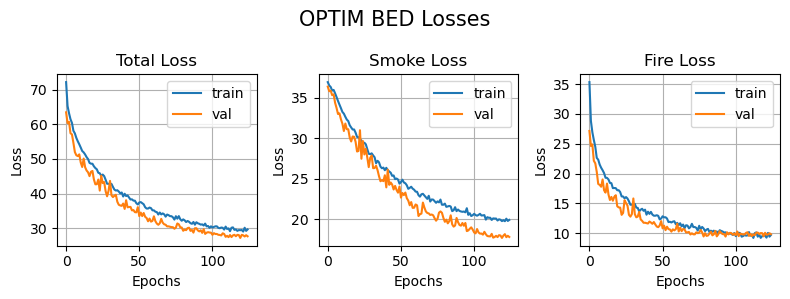

In [20]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()